### Loading the power traces

In [1]:
import pandas as pd

# Load the CSV file
traces = pd.read_csv("traces.csv", header=None)

# Display the shape of the dataset and first few rows to understand the structure
print(traces.shape)
print(traces.head())

(10000, 400)
    0     1     2     3     4     5     6     7     8     9    ...   390  \
0  1620  4315  5813  7012  7611  7910  7611  6412  5514  5214  ...  5813   
1 -3174  -777  1021  2218  2817  3117  2518  1620   422   122  ...  1021   
2 -3773  -477  1021  2218  2817  2817  2218  1320   721   122  ...   721   
3 -2275  -477  1320  2518  2817  2518  1620  1320   422  -178  ...  1021   
4  -777   422  1919  2817  3117  2817  1919   721   122  -178  ...  1021   

    391   392   393   394   395   396   397   398   399  
0  6412  6412  6412  6113  5813  5514  5514  5214  5514  
1  1320  1320  1320  1320  1021   721   721   422   721  
2  1021  1320  1320  1320  1021   721   422   422   422  
3  1021  1320  1320  1021   721   422   422   422  -178  
4  1620  1620  1320  1320   721   721   422   422  -477  

[5 rows x 400 columns]


### Plotting the first power trace

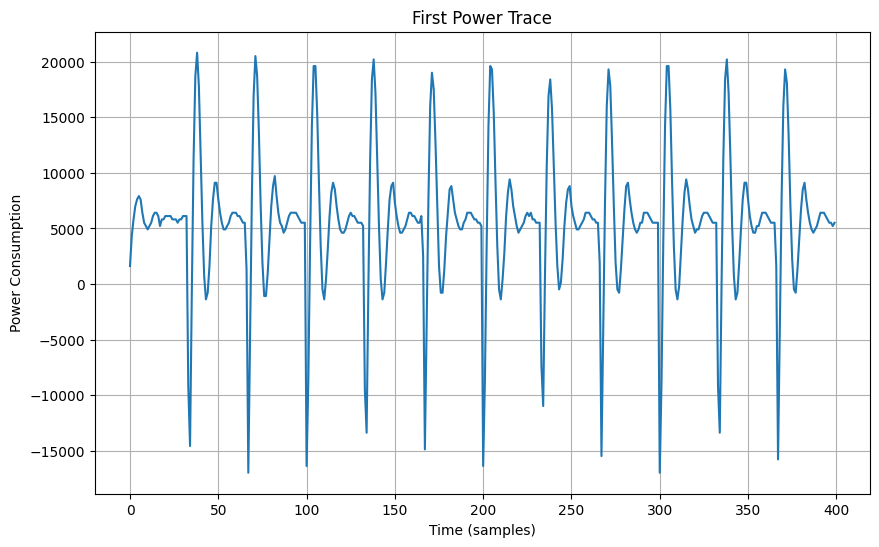

In [2]:
import matplotlib.pyplot as plt

# Plot the first power trace
first_trace = traces.iloc[0]

plt.figure(figsize=(10, 6))
plt.plot(first_trace)
plt.title("First Power Trace")
plt.xlabel("Time (samples)")
plt.ylabel("Power Consumption")
plt.grid(True)
plt.show()

### Plotting first 5 power traces

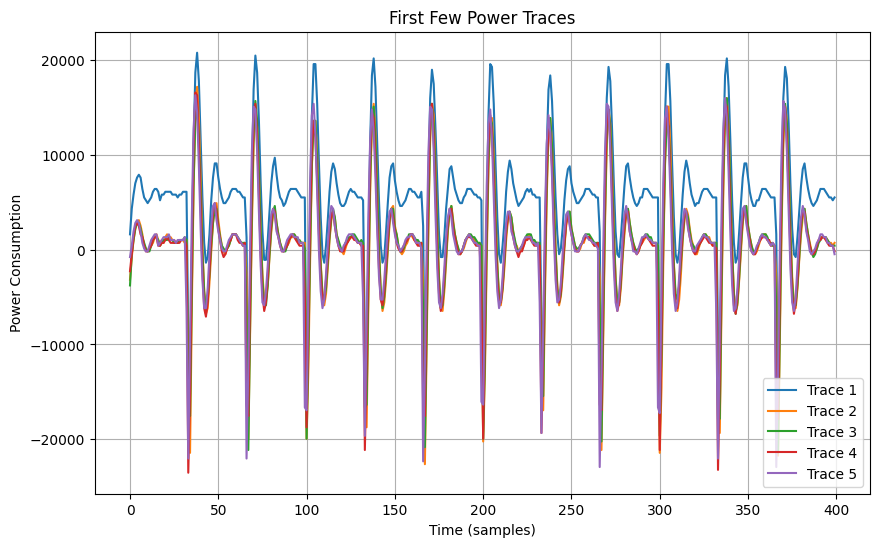

In [3]:
# Plot the first few power traces to visualize any misalignment
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot the first 5 traces
    plt.plot(traces.iloc[i], label=f'Trace {i+1}')

plt.title("First Few Power Traces")
plt.xlabel("Time (samples)")
plt.ylabel("Power Consumption")
plt.legend()
plt.grid(True)
plt.show()

### Aligning the power traces

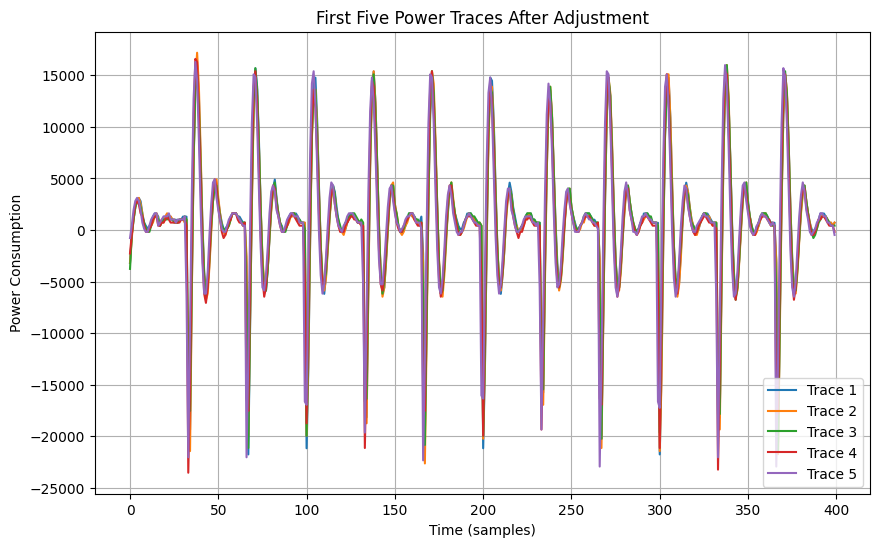

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file and convert to float
traces = pd.read_csv("traces.csv", header=None).astype(float)

# Number of traces to process
num_traces = min(10000, traces.shape[0])

# Calculate the mean shifted amount for each trace
shifted_amounts = np.mean(traces.iloc[0, :].values - traces.iloc[1:num_traces, :].values, axis=1)

# Calculate the overall average shift
average_shifted_amount = np.mean(shifted_amounts)

# Adjust the average shift
adjustment = -850
average_shifted_amount += adjustment

# Adjust the first trace by subtracting the updated average shift
traces.iloc[0, :] -= average_shifted_amount

# Plot the first five traces to check the alignment
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(traces.iloc[i, :], label=f'Trace {i + 1}')

plt.title('First Five Power Traces After Adjustment')
plt.xlabel('Time (samples)')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.show()


### DPA on the first byte of the key (LSB)

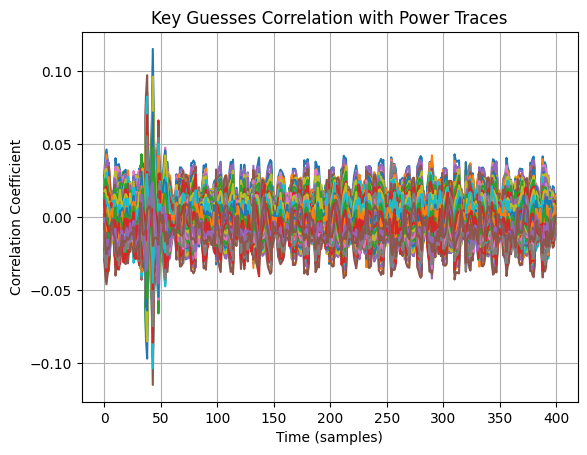

Max Correlation: 0.11498086462106895, Key Guess: 0xf0, Time Sample: 43
Min Correlation: -0.11498086462106885, Key Guess: 0x0f, Time Sample: 38


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read the input plaintexts from the file
with open('input_plaintext.txt', 'r') as f:
    c = f.readlines()

# Extract the first two characters from each line
in_hex = [line.strip()[-2:] for line in c]
in_dec = np.array([int(hx, 16) for hx in in_hex])

# print(in_hex)
# print(in_dec)

# XOR the plaintexts with key guesses [0..255]
s = np.zeros((10000, 256), dtype=int)
for i in range(10000):
    for j in range(256):
        s[i, j] = in_dec[i] ^ j

# Calculate the Hamming distance (HD) by counting the bits set to 1
hd = np.array([[bin(x).count('1') for x in row] for row in s])

# print(hd.shape)

# Power traces
pow = traces.values
time = np.arange(400)

# Correlation matrix
roh = np.zeros((400, 256))

# Calculate correlation b/w hd and power traces
for i in range(256):
    roh[:, i] = [np.corrcoef(hd[:, i], pow[:, t])[0, 1] for t in range(400)]
    plt.plot(time, roh[:, i], label=f'Key Guess {i}')

plt.title('Key Guesses Correlation with Power Traces')
plt.xlabel('Time (samples)')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()

# Find the maximum and minimum correlation values
maxplots = np.max(roh, axis=0)  # Max correlation for each key guess
minplots = np.min(roh, axis=0)  # Min correlation for each key guess

# Find the key guess with the highest correlation
max_corr = np.max(maxplots)
max_inx = np.argmax(maxplots)  # key_guess with highest corr

# Find the key guess with the lowest correlation
min_corr = np.min(minplots)
min_inx = np.argmin(minplots)  # key_guess with lowest corr

# Store the entire column that had the highest and lowest correlation
max_modelxtrace = roh[:, max_inx]
min_modelxtrace = roh[:, min_inx]

# Find the [time index] of the highest correlation in the best key guess
max_model = np.max(max_modelxtrace)
max_position = np.argmax(max_modelxtrace)

# Find the [time index] of the lowest correlation in the same trace
min_model = np.min(max_modelxtrace)
min_position = np.argmin(max_modelxtrace)

# Convert key guesses to hexadecimal
pos_max = f'{max_inx:02x}'  # Best key guess (2-digit hexadecimal)
pos_min = f'{min_inx:02x}'  # Worst key guess (2-digit hexadecimal)

# Output the results for maximum and minimum correlations
print(f"Max Correlation: {max_corr}, Key Guess: 0x{pos_max}, Time Sample: {max_position}")
print(f"Min Correlation: {min_corr}, Key Guess: 0x{pos_min}, Time Sample: {min_position}")


### Two best key guesses for first input byte (LSB)

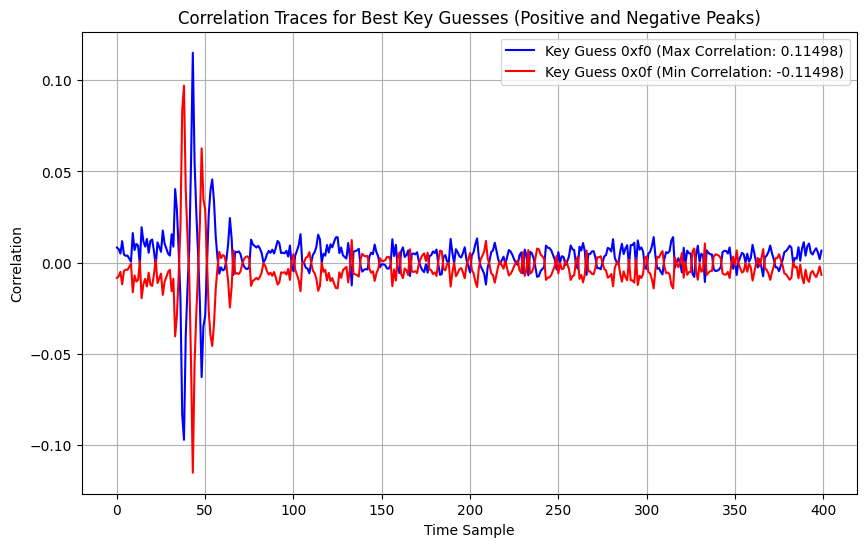

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# New Plotting for the best key guesses
plt.figure(figsize=(10, 6))

# Plot the correlation trace for the highest positive correlation
plt.plot(time, max_modelxtrace, label=f'Key Guess 0x{max_inx:02x} (Max Correlation: {max_corr:.5f})', color='blue')

# Plot the correlation trace for the most negative correlation
plt.plot(time, min_modelxtrace, label=f'Key Guess 0x{min_inx:02x} (Min Correlation: {min_corr:.5f})', color='red')

# Plot settings
plt.title('Correlation Traces for Best Key Guesses (Positive and Negative Peaks)')
plt.xlabel('Time Sample')
plt.ylabel('Correlation')
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()


### Key evolution plot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read the input plaintexts from the file
with open('input_plaintext.txt', 'r') as f:
    c = f.readlines()

in_hex = [line.strip() for line in c]
in_dec = np.array([[int(hx[i:i+2], 16) for i in range(0, len(hx), 2)] for hx in in_hex])  

# Number of key guesses, time samples, and bytes
num_key_guesses = 256
num_time_samples = 45
num_traces = 10000
num_bytes = 16

# Precompute Hamming distances
hd = np.zeros((num_traces, num_key_guesses, num_bytes), dtype=int)
for byte in range(num_bytes):
    for trace in range(num_traces):
        for key_guess in range(num_key_guesses):
            hd[trace, key_guess, byte] = bin(in_dec[trace, byte] ^ key_guess).count('1')

# Power traces
pow = traces.values 

# Function to calculate Pearson correlation in a vectorized way
def calculate_correlation_vectorized(hd_slice, pow, trace):
    corr = np.zeros((num_key_guesses, num_time_samples))
    for time in range(num_time_samples):
        # Check if we have at least 2 samples to calculate the correlation
        if trace > 0:  # Ensure there are at least two traces
            corr[:, time] = [
                pearsonr(hd_slice[:trace + 1, key_guess], pow[:trace + 1, time])[0] 
                if len(hd_slice[:trace + 1, key_guess]) > 1 and len(pow[:trace + 1, time]) > 1 else 0 
                for key_guess in range(num_key_guesses)
            ]
    return corr

# Initialize correlation matrix for 256 key guesses, 45 time samples, and 10000 traces
roh = np.zeros((num_key_guesses, num_time_samples, num_traces))

# Calculate correlations for each byte
for byte in range(num_bytes):
    print(f"Processing byte {byte + 1}/{num_bytes}...")

    # Slice the Hamming distances for the current byte
    hd_slice = hd[:, :, byte]

    # Loop through traces first (outer loop for efficiency)
    for trace in range(num_traces):
        # Vectorized computation of correlations for all key guesses and time samples
        roh[:, :, trace] = calculate_correlation_vectorized(hd_slice, pow, trace)

        # Log progress after every 100 traces or at the last trace
        if trace % 100 == 0 or trace == num_traces - 1:
            print(f"Processed {trace + 1}/{num_traces} traces.")

    # Plot correlation vs. number of traces for the current byte
    plt.figure(figsize=(10, 6))
    for key_guess in range(num_key_guesses):
        plt.plot(range(1, num_traces + 1), np.nanmax(roh[key_guess, :, :], axis=1), label=f'Key Guess {key_guess}', alpha=0.7)
    
    plt.title(f'Correlation vs Number of Measurements for Byte {byte}')
    plt.xlabel('Number of Measurements (Traces)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Finished processing byte {byte + 1}/{num_bytes}.")

print("All bytes processed.")

### DPA on 16 bytes

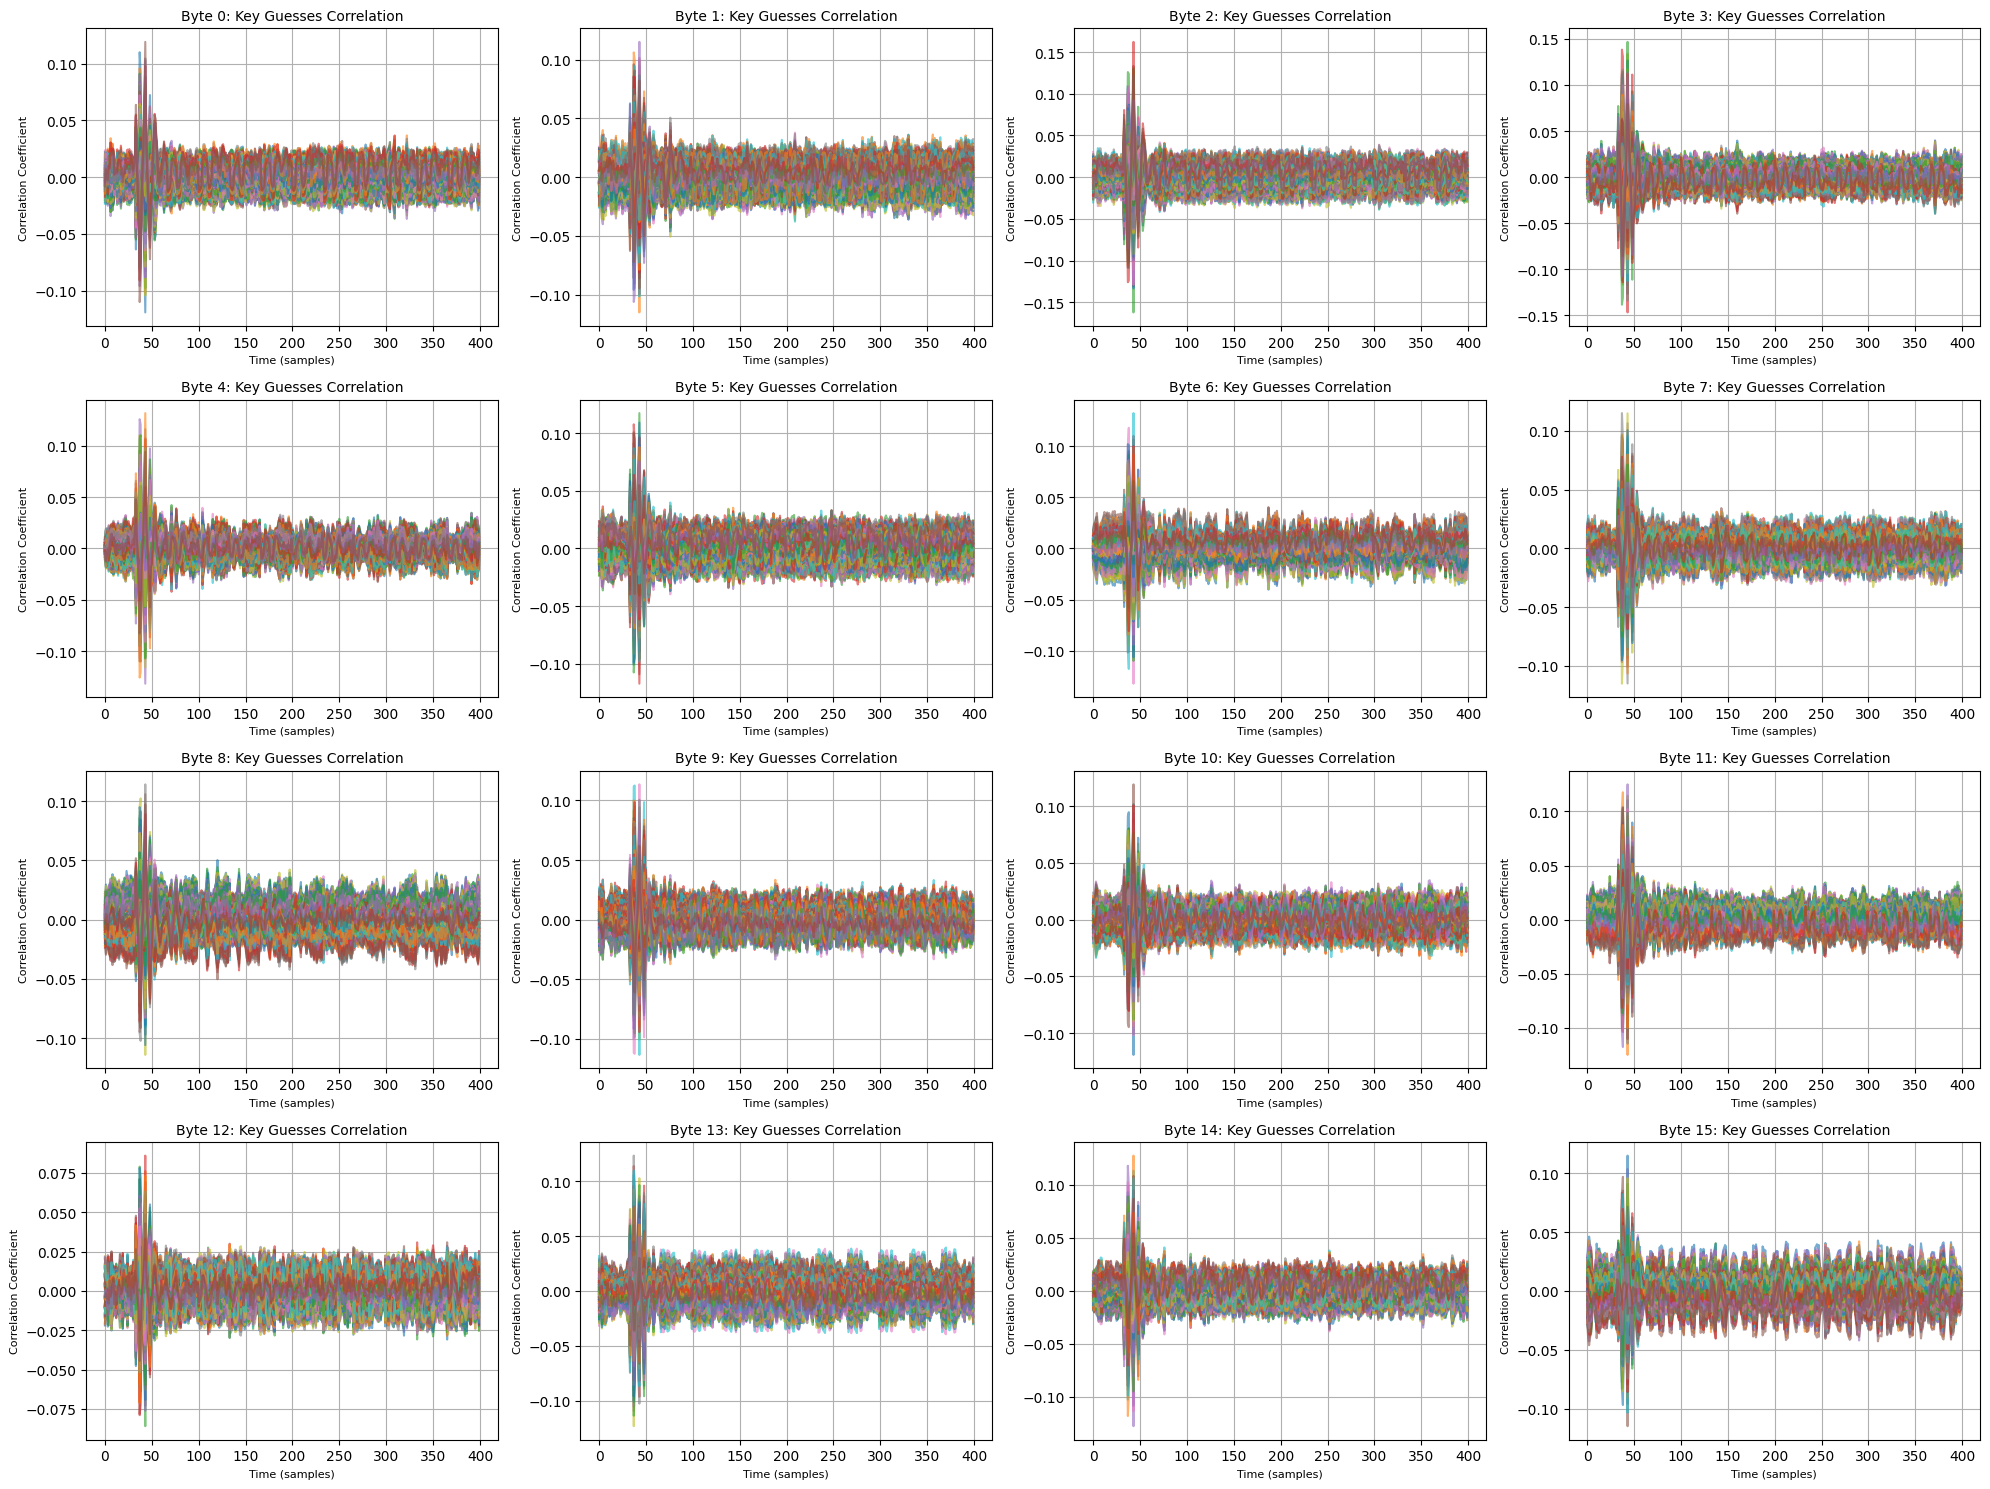

Byte 0: Top 1 Positive Correlation: 0.11905841991396265, Key Guess: 0xff, Time Sample: 43
Byte 0: Top 2 Positive Correlation: 0.10992584629300783, Key Guess: 0x00, Time Sample: 37
Byte 0: Top 1 Negative Correlation: -0.11905841991396265, Key Guess: 0x00, Time Sample: 43
Byte 0: Top 2 Negative Correlation: -0.10992584629300783, Key Guess: 0xff, Time Sample: 37


Byte 1: Top 1 Positive Correlation: 0.1151177148616907, Key Guess: 0xfe, Time Sample: 43
Byte 1: Top 2 Positive Correlation: 0.10618085420299023, Key Guess: 0x01, Time Sample: 37
Byte 1: Top 1 Negative Correlation: -0.1151177148616907, Key Guess: 0x01, Time Sample: 43
Byte 1: Top 2 Negative Correlation: -0.10618085420299023, Key Guess: 0xfe, Time Sample: 37


Byte 2: Top 1 Positive Correlation: 0.16220138904862016, Key Guess: 0xfd, Time Sample: 43
Byte 2: Top 2 Positive Correlation: 0.13339875646499424, Key Guess: 0xf5, Time Sample: 43
Byte 2: Top 1 Negative Correlation: -0.1622013890486203, Key Guess: 0x02, Time Sample: 43
Byte

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read the input plaintexts from the file
with open('input_plaintext.txt', 'r') as f:
    c = f.readlines()

# Extract the first 16 characters (representing 16 bytes) from each line
in_hex = [line.strip()[:32] for line in c]
in_dec = np.array([[int(line[i:i+2], 16) for i in range(0, 32, 2)] for line in in_hex])

# Assuming traces is a pandas DataFrame or similar; replace this with your actual data
pow = traces.values  # Replace with actual data source
time = np.arange(400)

# Define number of traces and number of key guesses
num_traces = in_dec.shape[0]
num_bytes = 16
num_key_guesses = 256

# Correlation matrix for all bytes
roh_all = np.zeros((400, num_key_guesses, num_bytes))

# Create a figure with subplots (4 rows and 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))  # Adjust figsize as needed

# Loop over all 16 bytes
for byte_idx in range(num_bytes):
    # XOR the plaintexts of the current byte with all possible key guesses [0..255]
    s = np.zeros((num_traces, num_key_guesses), dtype=int)
    for i in range(num_traces):
        for j in range(num_key_guesses):
            s[i, j] = in_dec[i, byte_idx] ^ j

    # Calculate the Hamming distance (HD) by counting the bits set to 1
    hd = np.array([[bin(x).count('1') for x in row] for row in s])

    # Correlation matrix for current byte
    roh = np.zeros((400, num_key_guesses))

    # Calculate correlation b/w hd and power traces for all time samples
    for i in range(num_key_guesses):
        roh[:, i] = [np.corrcoef(hd[:, i], pow[:, t])[0, 1] for t in range(400)]

    # Store correlation results for current byte
    roh_all[:, :, byte_idx] = roh

    # Plot the correlation for each key guess of the current byte
    ax = axes[byte_idx // 4, byte_idx % 4]  # Determine the subplot position
    for i in range(num_key_guesses):
        ax.plot(time, roh[:, i], label=f'Key Guess {i}', alpha=0.6)

    ax.set_title(f'Byte {byte_idx}: Key Guesses Correlation', fontsize=10)
    ax.set_xlabel('Time (samples)', fontsize=8)
    ax.set_ylabel('Correlation Coefficient', fontsize=8)
    ax.grid(True)

# Adjust layout to prevent overlap and save the figure
plt.tight_layout()
plt.show()

# Finding maximum and minimum correlations
for byte_idx in range(num_bytes):
    maxplots = np.max(roh_all[:, :, byte_idx], axis=0)
    minplots = np.min(roh_all[:, :, byte_idx], axis=0)

    top2_max_corr_indices = np.argsort(maxplots)[-2:][::-1]
    top2_min_corr_indices = np.argsort(minplots)[:2]

    for rank, idx in enumerate(top2_max_corr_indices, 1):
        max_time_sample = np.argmax(roh_all[:, idx, byte_idx])  
        print(f"Byte {byte_idx}: Top {rank} Positive Correlation: {maxplots[idx]}, Key Guess: 0x{idx:02x}, Time Sample: {max_time_sample}")

    for rank, idx in enumerate(top2_min_corr_indices, 1):
        min_time_sample = np.argmin(roh_all[:, idx, byte_idx])  
        print(f"Byte {byte_idx}: Top {rank} Negative Correlation: {minplots[idx]}, Key Guess: 0x{idx:02x}, Time Sample: {min_time_sample}")

    print("\n")


